# Exploratory Data Analysis (EDA)

This notebook presents an initial exploratory analysis of the credit card transactions dataset. The objective is to investigate potential differences between fraudulent and legitimate transactions and to identify useful patterns that can support the preprocessing and modeling steps.

Key points to be covered:
- Class imbalance overview (fraud vs. non-fraud)
- Temporal distribution of transactions (`Time`)
- Comparison of transaction amounts (`Amount`) across classes
- Behavior and interpretability of anonymized features (`V1` to `V28`)
- Correlation analysis across all features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import  os

sys.path.append(os.path.abspath(os.path.join("..")))
from src.data_loader import load_raw_data

# Visual settings
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_theme(style="whitegrid")


## Loading the dataset

We begin by loading the raw dataset using the helper function `load_raw_data()`. This file contains anonymized features (V1 to V28), the transaction timestamp (`Time`), the transaction amount (`Amount`), and the target label (`Class`), where 1 indicates fraud and 0 indicates a legitimate transaction.

In [2]:
df = load_raw_data()
df.shape

(284807, 31)

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


## Class distribution

It's important to understand how unbalanced the target variable is. In this case, the `Class` column tells us whether a transaction is fraudulent (`1`) or legitimate (`0`).

We'll count the number of occurrences of each class and also calculate the proportion of fraudulent transactions.

In [4]:
class_counts = df["Class"].value_counts()
class_percent = df["Class"].value_counts(normalize=True) * 100

display(pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percent
}))

,Count,Percentage
Class,,
0,284315,99.83
1,492,0.17


## Time analysis

The `Time` column represents the number of seconds elapsed between each transaction and the first transaction in the dataset. Although it's anonymized, it can still help us identify whether frauds are concentrated in certain periods.

We'll compare the distribution of `Time` for both legitimate and fraudulent transactions.

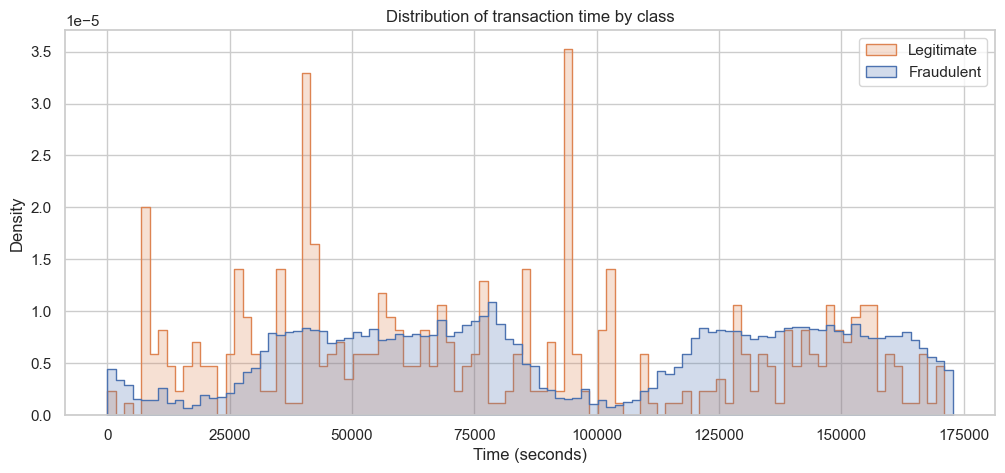

In [5]:
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x="Time", hue="Class", bins=100, element="step", stat="density", common_norm=False)
plt.title("Distribution of transaction time by class")
plt.xlabel("Time (seconds)")
plt.ylabel("Density")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

### Interpretation

This plot shows the distribution of transactions over time for each class, using density rather than raw counts. By normalizing each class separately (via `stat="density"` with `common_norm=False`), we can compare the **shapes** of the distributions even though the number of fraudulent transactions is much smaller than the number of legitimate ones.

Notably, there is a visible increase in fraud density between approximately 30,000 and 75,000 seconds and between 125,000 and 175,000 seconds, suggesting that certain periods may be more vulnerable to fraudulent activity. This temporal concentration could be leveraged later to create time-based features or to better understand behavioral patterns associated with fraud.

## Transaction amount analysis

The `Amount` feature represents the monetary value of each transaction. In this step, we aim to compare the distribution of transaction values between legitimate and fraudulent transactions.

Understanding whether fraud tends to occur in low, medium, or high-value transactions can help guide future feature engineering or model weighting strategies.

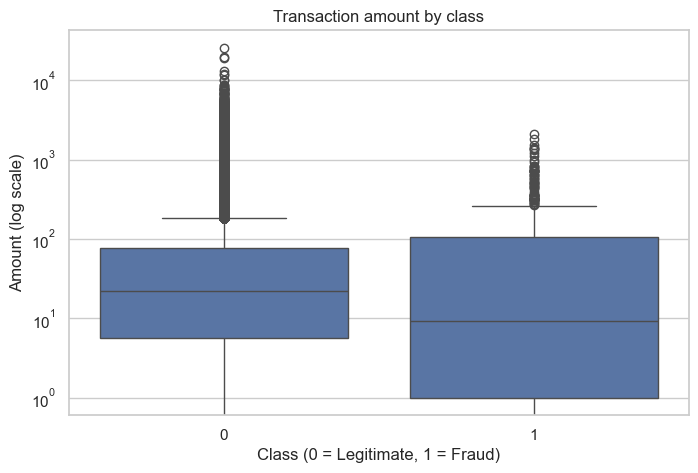

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Class", y="Amount")
plt.yscale("log")
plt.title("Transaction amount by class")
plt.xlabel("Class (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Amount (log scale)")
plt.show()

### Interpretation

The boxplot compares the transaction amounts between legitimate and fraudulent transactions, using a logarithmic scale on the y-axis to better visualize the wide value range and presence of outliers.

While both classes show the presence of high-value outliers, the **median transaction amount for frauds is lower** than that of legitimate transactions. However, the fraudulent transactions also exhibit a wider spread across the interquartile range (IQR), indicating greater variability in value.

This suggests that frauds are not necessarily associated with high-value transactions, and in fact, may often occur at smaller amounts — possibly to avoid detection. The high variance, though, indicates that value alone is not a reliable indicator of fraud, but may contribute meaningfully when combined with other features.

## Analysis of anonymized features (V1 to V28)

The dataset includes 28 anonymized numerical features named `V1` through `V28`. These were created using a dimensionality reduction technique (PCA), so their individual meanings are not known.

Even though we can't interpret them semantically, we can still analyze their distributions and look for patterns that differentiate fraudulent from legitimate transactions.


<Figure size 1200x500 with 0 Axes>

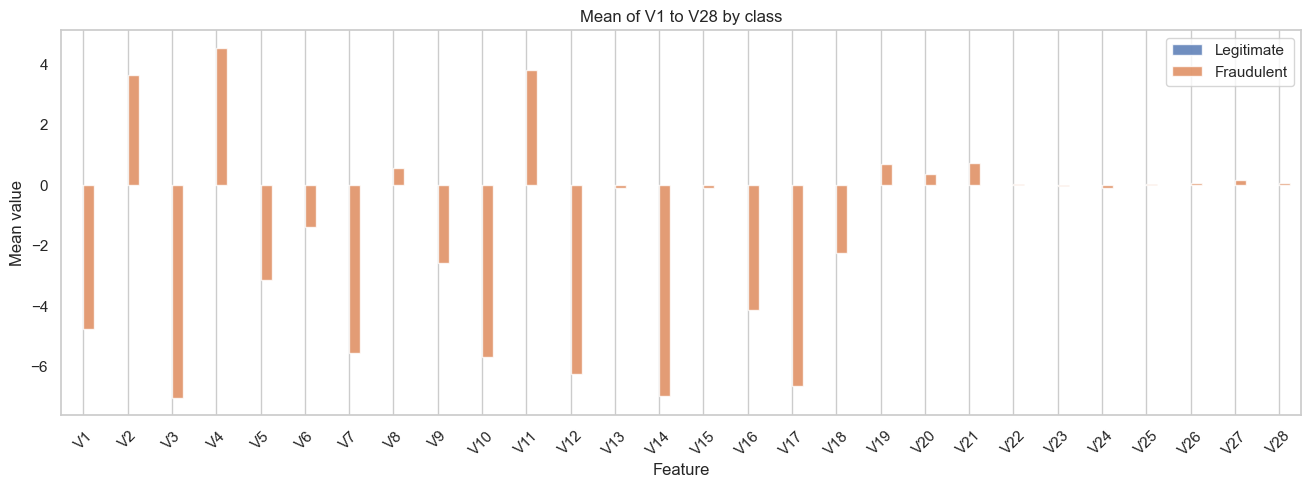

In [7]:
v_features = [f"V{i}" for i in range(1, 29)]

mean_by_class = df.groupby("Class")[v_features].mean().T
mean_by_class.columns = ["Legitimate", "Fraudulent"]

plt.figure(figsize=(12, 5))
mean_by_class.plot(kind="bar", figsize=(16, 5), alpha=0.8)
plt.title("Mean of V1 to V28 by class")
plt.ylabel("Mean value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Interpretation

This plot shows the average value of each anonymized feature (`V1` to `V28`) for both legitimate and fraudulent transactions.

We observe that the mean value of **legitimate transactions tends to be close to zero**. This is expected, since these features were generated using Principal Component Analysis (PCA), a technique that standardizes the data (zero mean and unit variance) before projecting it into a new feature space. Given that the vast majority of transactions are legitimate, this transformation causes the principal components to be centered around zero for the non-fraudulent class.

In contrast, several features show **large mean values for fraudulent transactions**, particularly:
-`V1`, `V2`, `V3`, `V4`, `V7`, `V10`, `V11`, `V12`, `V14`, `V16` and `V17`.

These deviations indicate that fraudulent behavior causes a measurable impact in those components, suggesting that these features may be highly informative for classification.

Other components exhibit minimal differences between classes, which may imply limited individual predictive power — though they can still contribute in combination with other features.

## Correlation matrix

To better understand the relationships among the features, we will compute and visualize the correlation matrix.

This helps identify highly correlated variables, which may be redundant or provide similar information to the model. We'll include the PCA features (`V1` to `V28`) as well as `Amount` and `Time`.


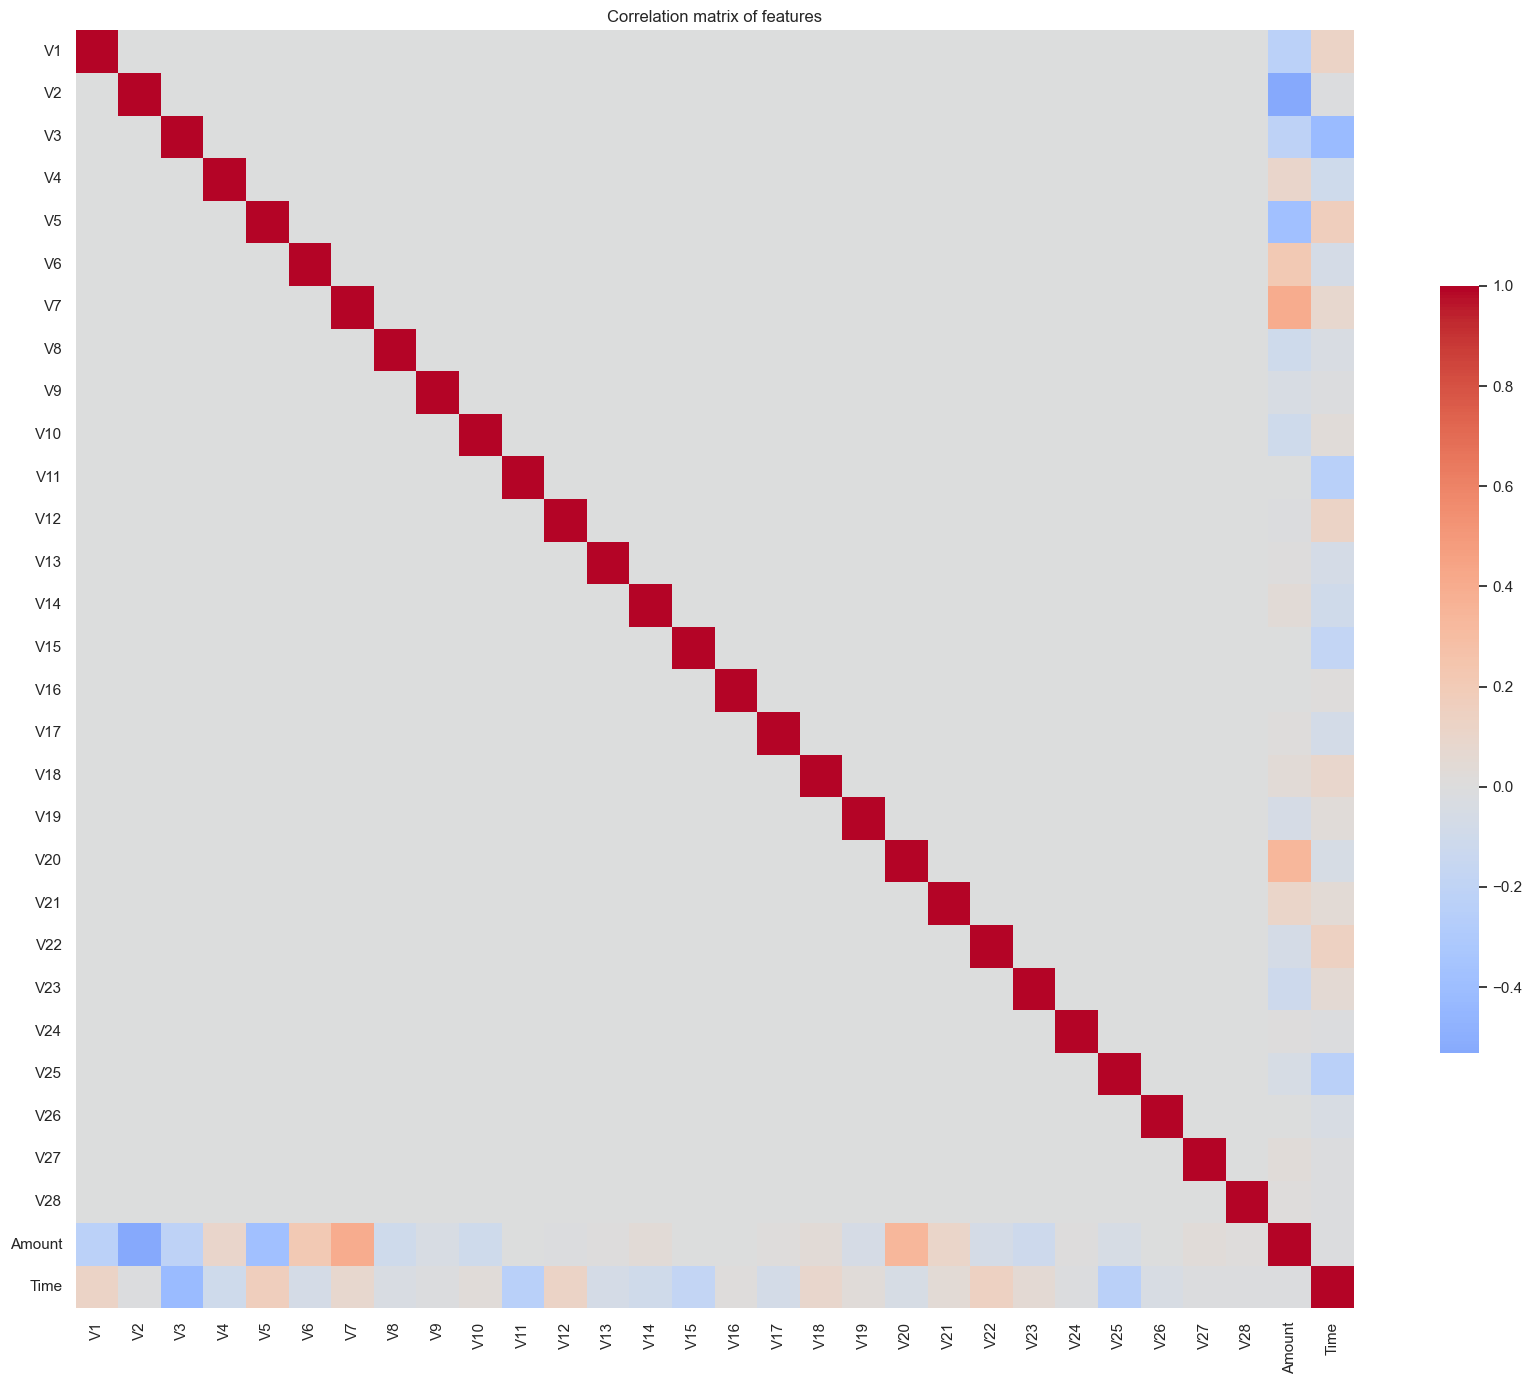

In [10]:
corr_features = [f"V{i}" for i in range(1, 29)] + ["Amount", "Time"]

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f", square=True, cbar_kws={"shrink": 0.6})
plt.title("Correlation matrix of features")
plt.tight_layout()
plt.show()


In [14]:
v_features = [f"V{i}" for i in range(1, 29)]

amount_corr = df[v_features + ["Amount"]].corr()["Amount"].drop("Amount")
time_corr = df[v_features + ["Time"]].corr()["Time"].drop("Time")

amount_corr_sorted = amount_corr.abs().sort_values(ascending=False)
time_corr_sorted = time_corr.abs().sort_values(ascending=False)

print("Top 10 correlations with Amount:\n")
display(pd.DataFrame({"Corr with Amount": amount_corr[amount_corr_sorted.index].head(10)}))

print("\nTop 10 correlations with Time:\n")
display(pd.DataFrame({"Corr with Time": time_corr[time_corr_sorted.index].head(10)}))


Top 10 correlations with Amount:



,Corr with Amount
V2,-0.53
V7,0.40
V5,-0.39
V20,0.34
V1,-0.23
V6,0.22
V3,-0.21
V23,-0.11
V21,0.11
V8,-0.10



Top 10 correlations with Time:



,Corr with Time
V3,-0.42
V11,-0.25
V25,-0.23
V15,-0.18
V5,0.17
V22,0.14
V12,0.12
V1,0.12
V4,-0.11
V14,-0.10


### Interpretation

The heatmap and correlation table provide a comprehensive view of how the features relate to each other and to the variables `Amount` and `Time`.

As expected, most of the anonymized features (`V1` to `V28`) exhibit near-zero correlation among themselves. This is a direct consequence of the PCA transformation applied to the original data. This reinforces the idea that each component captures unique information, reducing redundancy across features.

Looking specifically at the relationships with `Amount`, some features stand out:
- `V2` and `V5`show moderate negative correlations (-0.53 and -0.39).
- `V7` and `V20` show moderate positive correlations (0.40 and 0.34).
- Other features like `V1`, `V6` and `V3` also exhibit non-negligible correlations, either positive or negative.

This indicates that certain components are somewhat sensitive to the monetary value of the transaction, which may carry useful information for detecting atypical behavior or high-value fraud.

Looking specifically at the relationships with `Time`, the correlations are generally weaker, but a few features still stand out:
- `V3` shows a weak-to-moderate negative correlation (-0.42).
- Other features like `V11`, `V25`, `V15` and `V5` also exhibit non-negligible correlations, either positive or negative.

Overall, while `Time` does not appear to strongly influence most features, the negative correlation observed in `V3` might reflect subtle temporal effects that could be explored further or leveraged during feature engineering.